#**Importamos librerias**

In [ ]:
!pip install category_encoders
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

import category_encoders as ce
import umap
from sklearn.preprocessing import StandardScaler

import pickle
import joblib

#**Importamos data**

In [ ]:
def cargarDataFrame(url):
  headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
  req = requests.get(url, headers=headers)
  data = StringIO(req.text)
  df = pd.read_csv(data)
  return df

In [ ]:
url='https://littlegigant.com/hackathon_bbva/df_final.csv'
df=cargarDataFrame(url)

In [ ]:
# vaciamos las columnas sin importancia y las filas con nulos

df.dropna(axis=0, how='any',inplace=True)

df.drop(columns=['Unnamed: 0','CODIGO_CLIENTE','PERIODO','NUMERO_DOCUMENTO'],inplace=True)

In [ ]:
# Vamos a llevarnos la columna de interes nada mas

encoder = ce.BinaryEncoder(cols='UBIGEO_DIRECCION')

dataset= encoder.fit_transform(df)

dataset.sample(5)

#DATASET LISTOOOOOOOOOOOOOO

,EDAD,UBIGEO_DIRECCION_0,UBIGEO_DIRECCION_1,UBIGEO_DIRECCION_2,UBIGEO_DIRECCION_3,UBIGEO_DIRECCION_4,UBIGEO_DIRECCION_5,UBIGEO_DIRECCION_6,UBIGEO_DIRECCION_7,UBIGEO_DIRECCION_8,UBIGEO_DIRECCION_9,UBIGEO_DIRECCION_10,SEGMENTO_COMERCIAL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE,INGRESO_MENSUAL,GRUPO_RIESGO,RIESGO1,RIESGO2,TIPO_DOCUMENTO,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,GENERO_M,ESTADO_CIVIL_D,ESTADO_CIVIL_OTROS,ESTADO_CIVIL_S,ESTADO_CIVIL_V
128084,33.0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2214.13,2,2,2,1,0.0,7204.21,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.00,0.0,0,0,8729.39,119.865698,1256.330000,1376.195698,0.0000,0.000000,831.136016,237.393758,3.501086,1,0,0,1,0
392357,27.0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1599.75,1,0,0,1,0.0,196.85,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.00,0.0,0,0,1.68,0.059685,4.474193,4.533878,0.0000,0.000000,3.196383,12.461729,0.256496,1,0,0,1,0
891434,39.0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1728.59,0,0,0,1,0.0,345.50,2417.29,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0.00,0.0,1,0,4488.12,143.585549,0.000000,143.585549,0.0000,0.000000,81.075905,24.768507,3.273346,1,0,0,0,0
282156,32.0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1653.27,1,0,0,1,0.0,10.62,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0.00,0.0,0,0,6.41,0.235814,0.000000,0.235814,0.0000,0.000000,0.166249,0.041562,4.000003,1,0,0,1,0
843936,58.0,0,0,0,1,1,0,1,1,0,0,1,1,1,1,7402.93,1,0,0,1,0.0,43179.12,15326.15,0.0,0.0,0.0,45391.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,1,1,45391.44,0.0,1,0,38897.94,1847.261508,197.217742,2044.479250,66811.4647,248.473023,779.749846,1706.974771,0.456802,1,1,0,0,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800253 entries, 0 to 919323
Data columns (total 64 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   EDAD                               800253 non-null  float64
 1   UBIGEO_DIRECCION_0                 800253 non-null  int64  
 2   UBIGEO_DIRECCION_1                 800253 non-null  int64  
 3   UBIGEO_DIRECCION_2                 800253 non-null  int64  
 4   UBIGEO_DIRECCION_3                 800253 non-null  int64  
 5   UBIGEO_DIRECCION_4                 800253 non-null  int64  
 6   UBIGEO_DIRECCION_5                 800253 non-null  int64  
 7   UBIGEO_DIRECCION_6                 800253 non-null  int64  
 8   UBIGEO_DIRECCION_7                 800253 non-null  int64  
 9   UBIGEO_DIRECCION_8                 800253 non-null  int64  
 10  UBIGEO_DIRECCION_9                 800253 non-null  int64  
 11  UBIGEO_DIRECCION_10                8002

In [ ]:
categorical_cols=[

                  dataset.columns[k]

                    for k in range(len(dataset.columns))

                        if

                            dataset[dataset.columns[k]].dtype
                                            in ['int64']

                    ]

float_cols=[

                  dataset.columns[k]

                    for k in range(len(dataset.columns))

                        if

                            dataset[dataset.columns[k]].dtype
                                            in ['float64']

                    ]


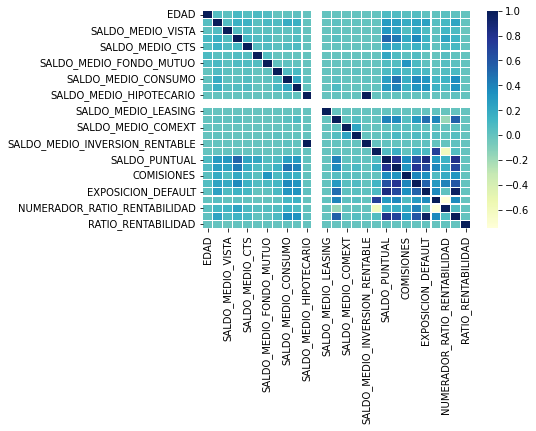

In [ ]:
# analizamos las correlaciones linales de las variables continuas
corr = dataset[float_cols].corr(method = 'pearson')
mask = np.zeros_like(corr)
sns.heatmap(corr, annot=False,linewidths=0.1,cmap="YlGnBu")

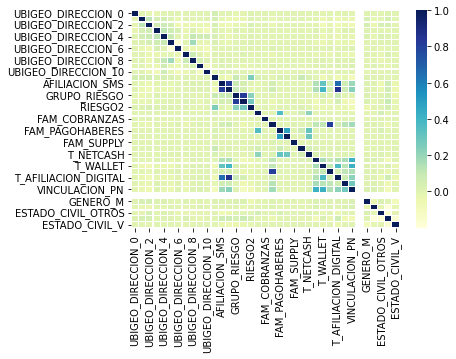

In [ ]:
# correlacion entre variables

# analizamos las correlaciones linales de las variables continuas
corr = dataset[categorical_cols].corr(method = 'pearson')
mask = np.zeros_like(corr)
sns.heatmap(corr, annot=False,linewidths=0.1,cmap="YlGnBu")

In [ ]:
# Estandarizamos las variables de entrada

# extraemos el target antes

data_original=dataset.copy()

target_cols=['NUMERADOR_RATIO_RENTABILIDAD','DENOMINADOR_RATIO_RENTABILIDAD',
                                'RATIO_RENTABILIDAD']

target=dataset[target_cols]


float_norm=dataset.drop( columns=categorical_cols+ target_cols,axis=1 )

scaler=StandardScaler().fit(float_norm)

features_float_cols=filtered_list=[float_feature for float_feature in float_cols
                                   if float_feature not in target_cols]

float_norm=pd.DataFrame(
        scaler.transform(float_norm),
        columns=features_float_cols,index=dataset.index)

dataset.drop(columns=float_cols,inplace=True)

dataset=pd.concat([dataset,float_norm,target], axis=1)

# es demasiado grande para trabajarlo vamos a trabajar con una muestra

muestra=dataset.sample(5000)

target=muestra[target_cols]

features=muestra.drop(columns=target_cols,axis=1 )



In [ ]:
joblib.dump(scaler,'scaler.joblib')

['scaler.joblib']

In [ ]:
# aplicamos UMAP

reducer = umap.UMAP()
embedding = reducer.fit_transform(features)
embedding.shape


(5000, 2)

In [ ]:
joblib.dump(embedding,'umap.joblib')

['umap.joblib']

Text(0.5, 1.0, 'UMAP Clientes BBVA')

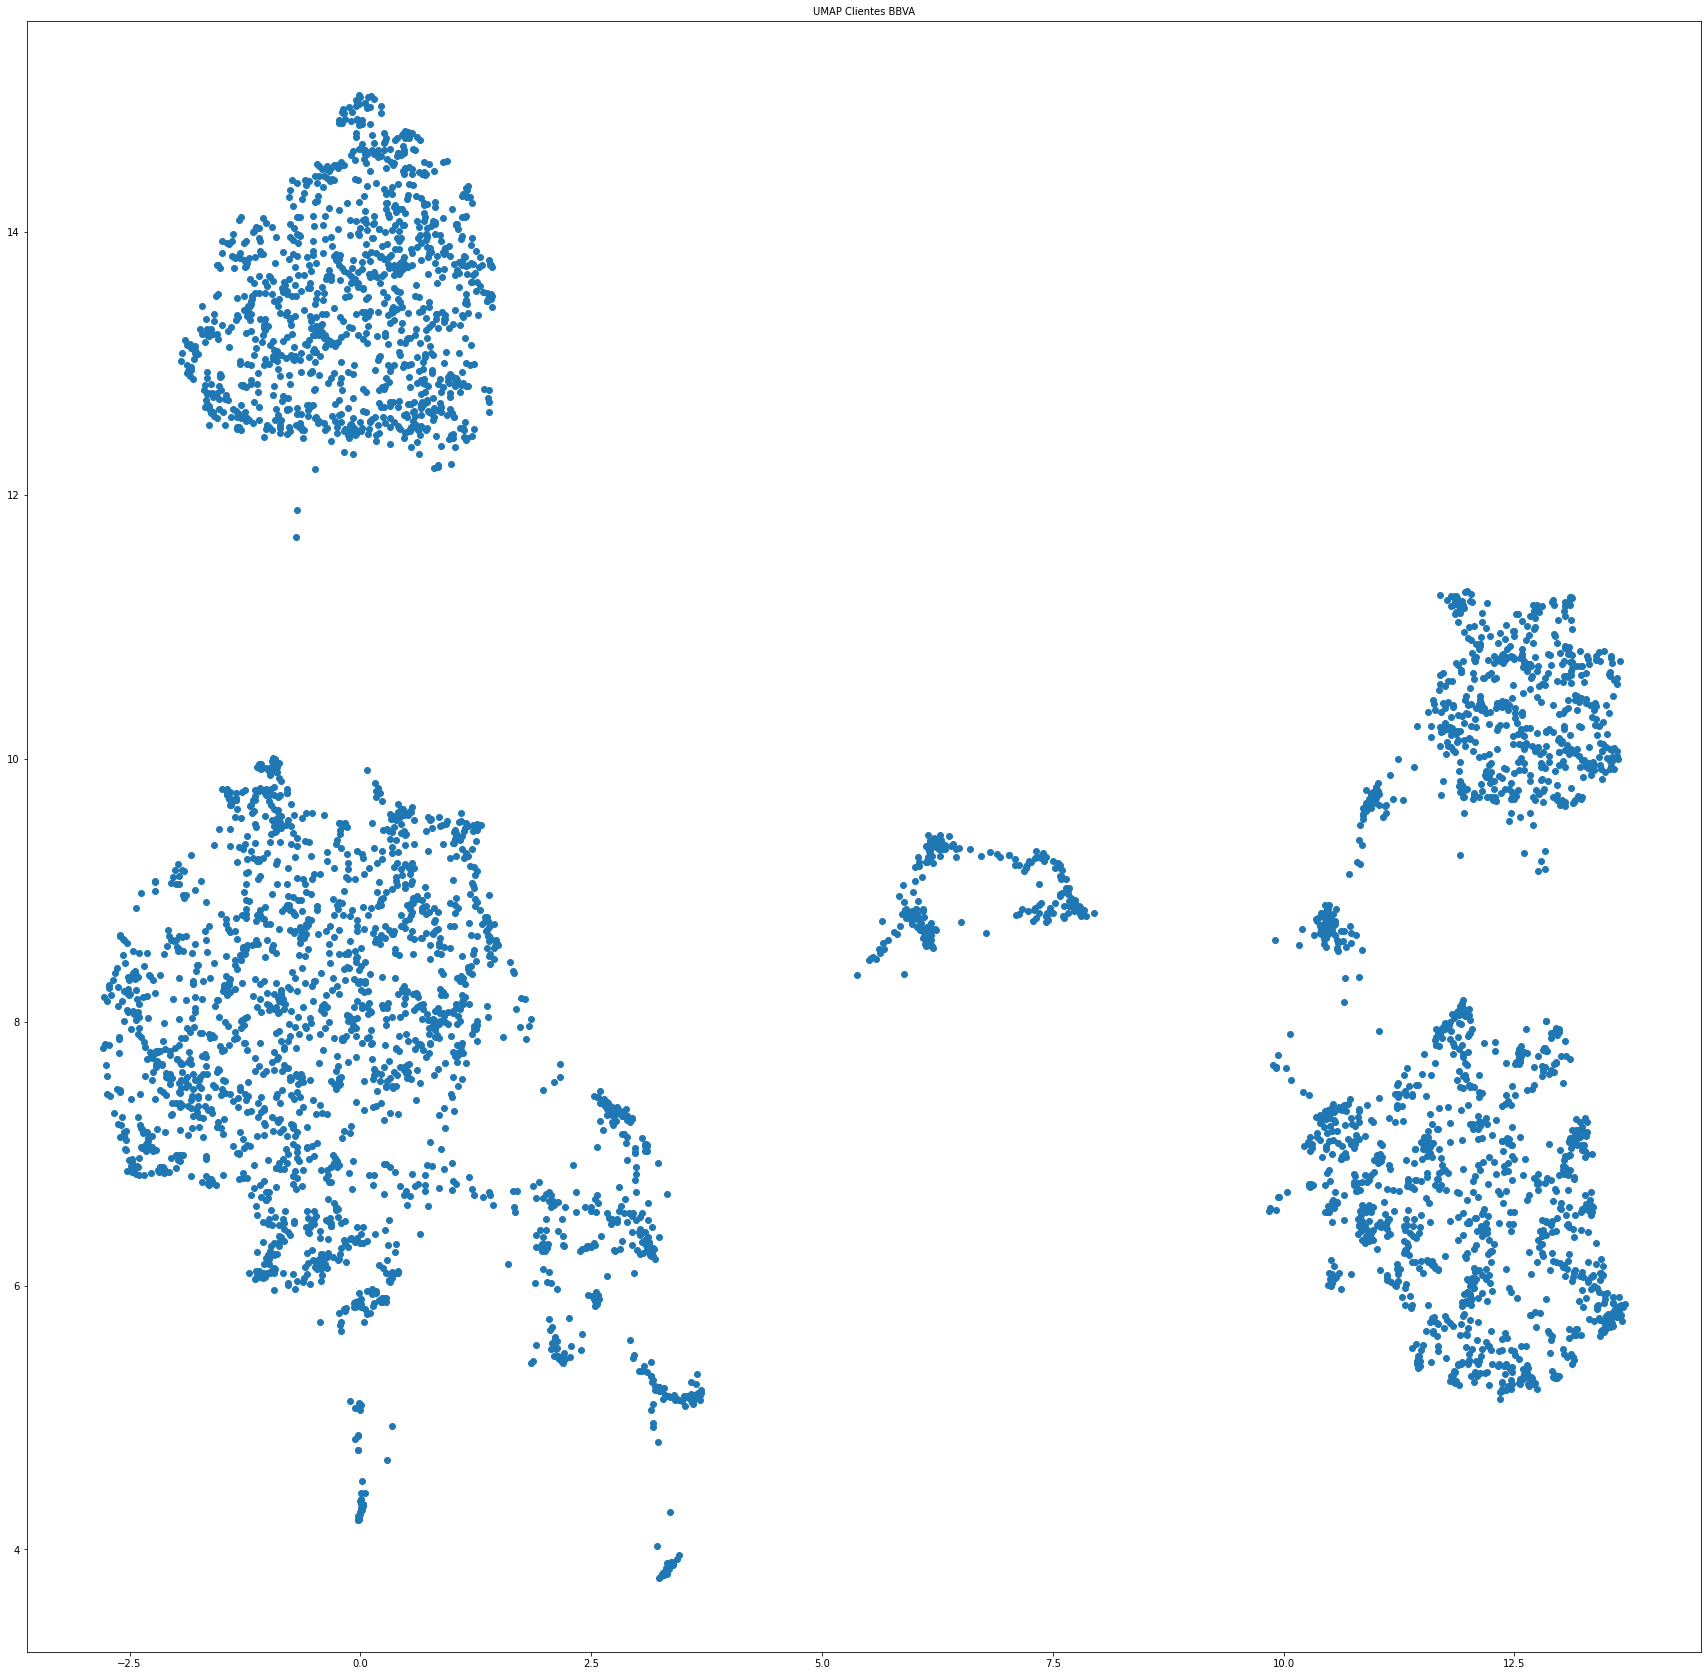

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1] )
plt.title('UMAP Clientes BBVA', fontsize=10)

In [ ]:
# clusterizamos

from sklearn.cluster import DBSCAN

db_clustering = DBSCAN(eps=1, min_samples=50).fit(embedding)



Text(0.5, 1.0, 'UMAP Clientes BBVA')

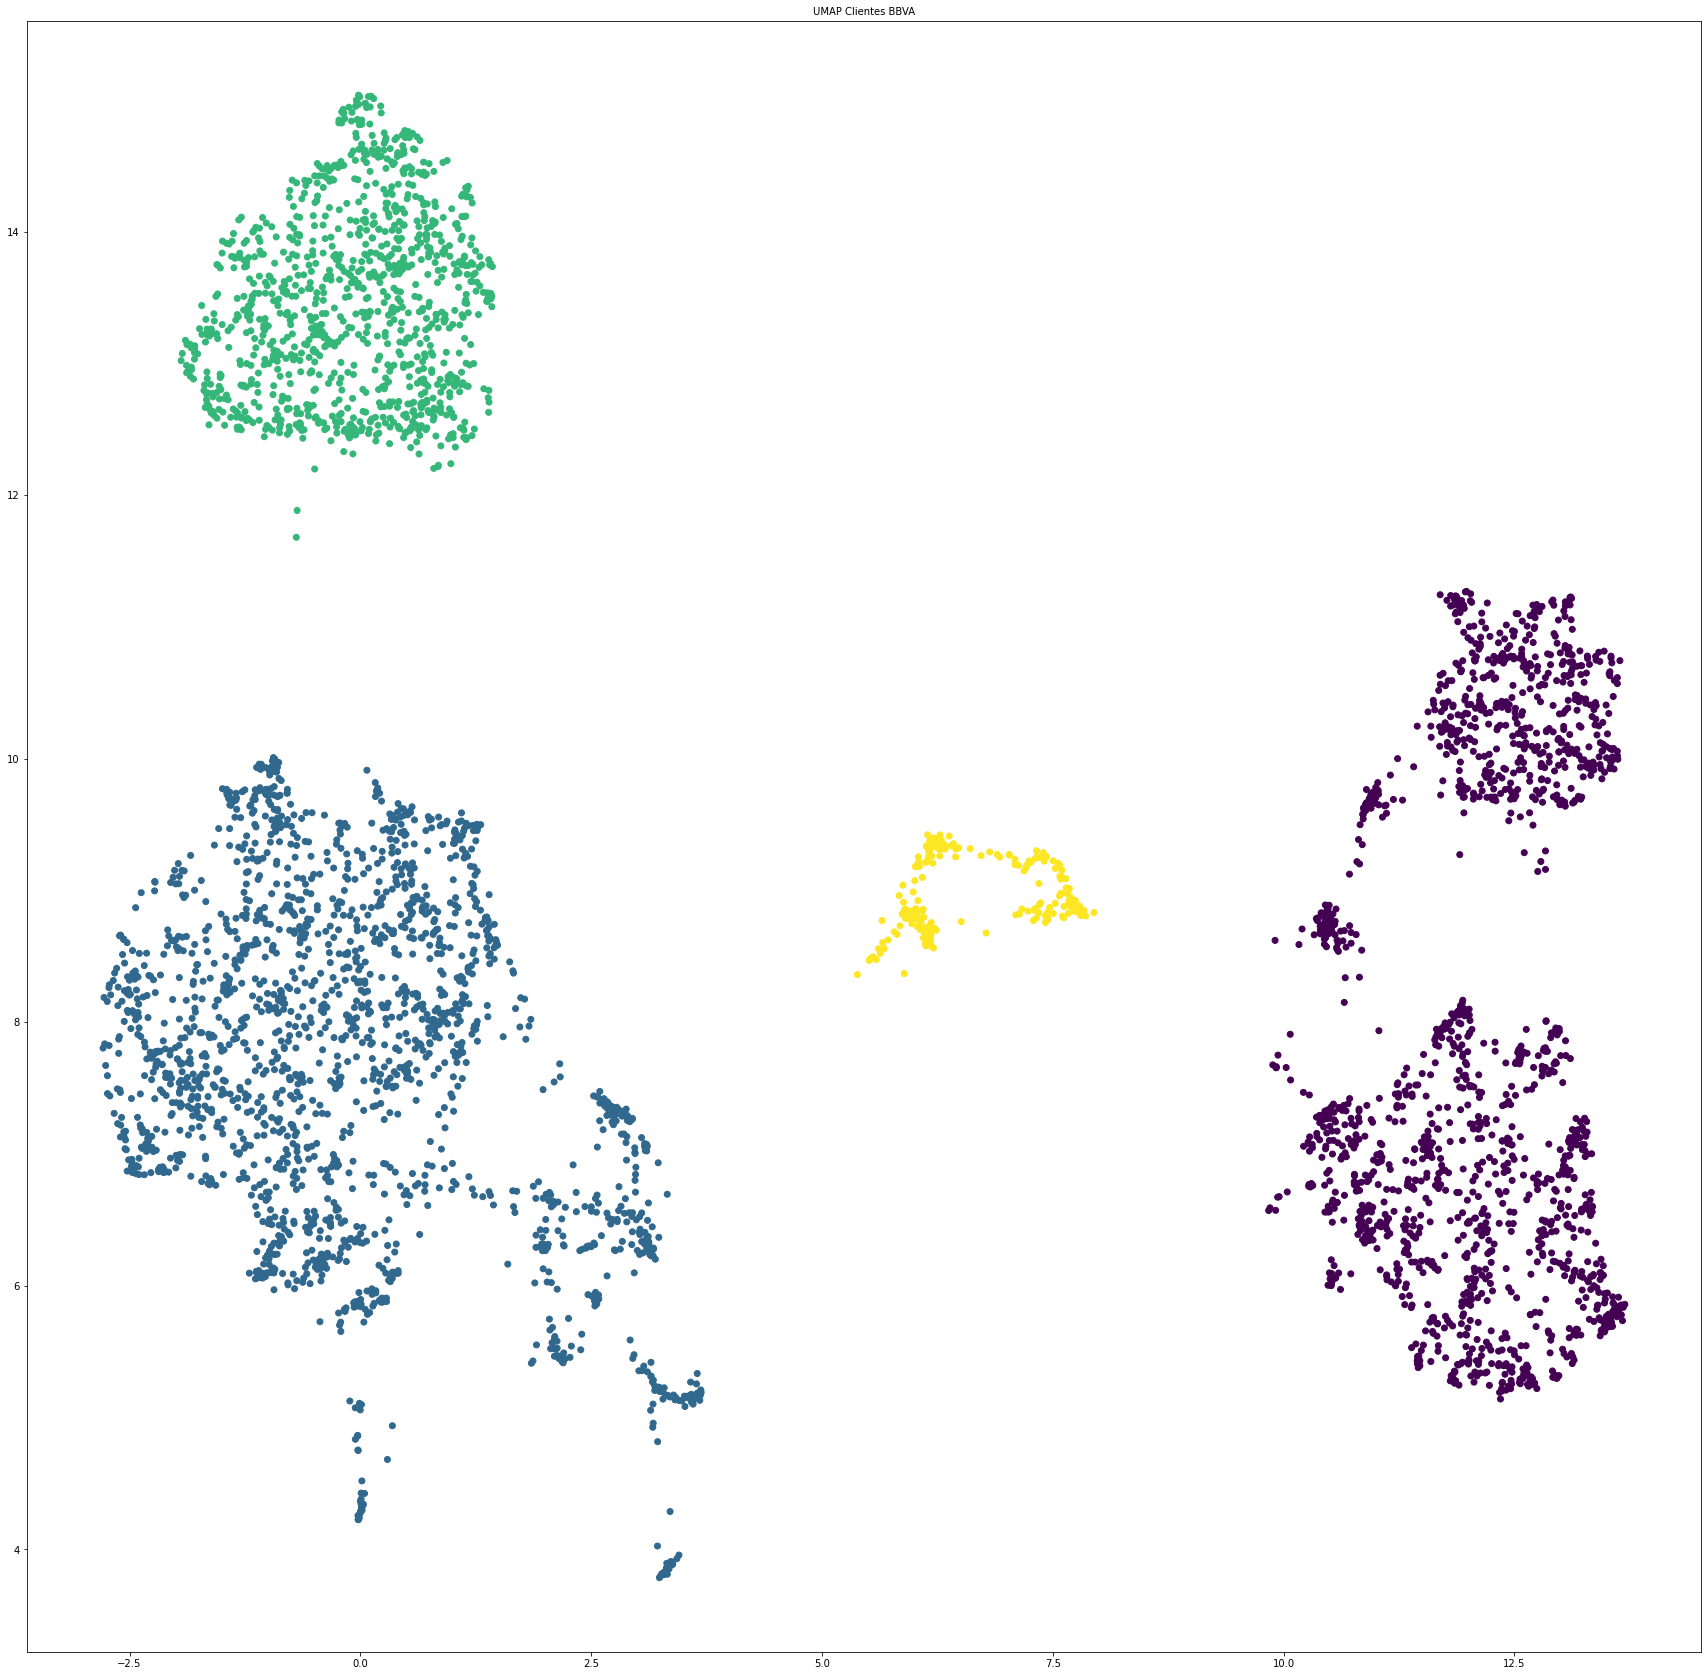

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c= db_clustering.labels_ )
plt.title('UMAP Clientes BBVA', fontsize=10)

In [ ]:
# vamos a estudiar el calculo conjunto del ratio para cada cluster

labels=db_clustering.labels_

labels=pd.Series(labels,name='labels',index=features.index)

# debemos suprimir los OUTLIERS

data_etiquetada=pd.concat(objs=[features,target,labels],axis=1)

# Suprimimos los outliers

data_etiquetada=data_etiquetada[data_etiquetada['labels']!=-1]


In [ ]:
data_etiquetada.to_csv('etiquetada.csv', index=False,)

In [ ]:
# primero vamos a reducir dimensiones

from sklearn.decomposition import PCA
pca = PCA(n_components=27)
pca.fit(data_etiquetada.drop(columns=target_cols+['labels'],axis=1))
print(sum(pca.explained_variance_ratio_))

X=pca.transform(data_etiquetada.drop(columns=target_cols+['labels'],axis=1))

0.938750093309205


In [ ]:
joblib.dump(pca,'pca.joblib')

['pca.joblib']

In [ ]:
pd.DataFrame(X).to_csv('X.csv', index=False)

In [ ]:
# podemos ir con el calsificador

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score



In [ ]:


x_train, x_test, y_train, y_test = train_test_split(
    X, data_etiquetada['labels'], test_size=0.33, random_state=42)

reg_svc=SVC(C=1,gamma='scale',kernel='rbf')

reg_svc.fit(x_train,y_train)

print(reg_svc.score(x_test,y_test))

0.9927272727272727


In [ ]:
joblib.dump(reg_svc,'clf.joblib')

['clf.joblib']

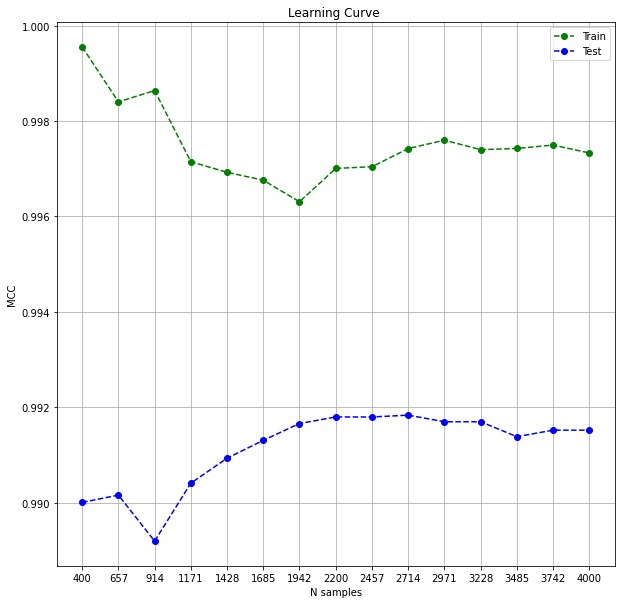

In [ ]:
from sklearn.model_selection import learning_curve

samples,train,test = learning_curve(
    reg_svc,
    X,data_etiquetada['labels'],
    train_sizes=np.linspace(0.1,1,15),
    scoring='f1_macro')

train=np.mean(train,axis=1).reshape(-1,1)
test=np.mean(test,axis=1).reshape(-1,1)
samples=samples.reshape(-1,1)

# graficamos los resultados

plt.figure(figsize=(10,10))
plt.plot(samples,train,'go--')
plt.plot(samples,test,'bo--')
plt.legend(['Train','Test'])
plt.title('Learning Curve ')
plt.xlabel('N samples')
plt.ylabel('MCC')
plt.xticks(samples);
plt.grid()

# No esta ovverfitieado


In [ ]:
# vamos a ver como recomendar


# En primer lugar el clasificador nos dira si el cliente esta o no
# en un cluster de alta rentabilidad

# luego de escoger los clientes que esten en los clusters mas rentables
# se debe estimar los productos de mayor probabildiad de tenencia, en caso
# de no tenerlos se recomiendan

data_original.columns


Index(['EDAD', 'UBIGEO_DIRECCION_0', 'UBIGEO_DIRECCION_1',
       'UBIGEO_DIRECCION_2', 'UBIGEO_DIRECCION_3', 'UBIGEO_DIRECCION_4',
       'UBIGEO_DIRECCION_5', 'UBIGEO_DIRECCION_6', 'UBIGEO_DIRECCION_7',
       'UBIGEO_DIRECCION_8', 'UBIGEO_DIRECCION_9', 'UBIGEO_DIRECCION_10',
       'SEGMENTO_COMERCIAL', 'AFILIACION_SMS', 'AFILIACION_BANCA_ONLINE',
       'INGRESO_MENSUAL', 'GRUPO_RIESGO', 'RIESGO1', 'RIESGO2',
       'TIPO_DOCUMENTO', 'SALDO_MEDIO_VISTA', 'SALDO_MEDIO_AHORRO',
       'SALDO_MEDIO_CTS', 'SALDO_MEDIO_PLAZO', 'SALDO_MEDIO_FONDO_MUTUO',
       'SALDO_MEDIO_AUTOS', 'SALDO_MEDIO_CONSUMO', 'SALDO_MEDIO_TARJETAS',
       'SALDO_MEDIO_HIPOTECARIO', 'SALDO_MEDIO_CARTERA', 'SALDO_MEDIO_LEASING',
       'SALDO_MEDIO_PRESTAMOS_COMERCIALES', 'SALDO_MEDIO_COMEXT',
       'SALDO_MEDIO_TJ_EMPRESAS', 'FAM_COBRANZAS', 'FAM_COMEX',
       'FAM_PAGOHABERES', 'FAM_PROVEEDORES', 'FAM_SUPPLY', 'FAM_VISANET',
       'T_NETCASH', 'T_SEGURO', 'T_WALLET', 'T_TCAMBIO',
       'T_AFILIACION_DIGI

In [ ]:
# productos

productos_categoricos=['FAM_COBRANZAS', 'FAM_COMEX',
       'FAM_PAGOHABERES', 'FAM_PROVEEDORES', 'FAM_SUPPLY', 'FAM_VISANET',
       'T_NETCASH', 'T_SEGURO', 'T_WALLET', 'T_TCAMBIO',
       'T_AFILIACION_DIGITAL', 'T_CARGO_RECURRENTE']

productos_saldo=['SALDO_MEDIO_VISTA', 'SALDO_MEDIO_AHORRO',
       'SALDO_MEDIO_CTS', 'SALDO_MEDIO_PLAZO', 'SALDO_MEDIO_FONDO_MUTUO',
       'SALDO_MEDIO_AUTOS', 'SALDO_MEDIO_CONSUMO', 'SALDO_MEDIO_TARJETAS',
       'SALDO_MEDIO_HIPOTECARIO', 'SALDO_MEDIO_CARTERA', 'SALDO_MEDIO_LEASING',
       'SALDO_MEDIO_PRESTAMOS_COMERCIALES', 'SALDO_MEDIO_COMEXT',
       'SALDO_MEDIO_TJ_EMPRESAS', 'SALDO_MEDIO_INVERSION_RENTABLE']

In [ ]:
data_original=data_original.sample(10000)


X_recomendacion=data_original.drop(
    axis=1,columns=productos_categoricos+productos_saldo)

In [ ]:
target_recomendacion=(
    data_original[productos_categoricos+productos_saldo].astype(float).
    applymap(lambda row: 1 if row!=0 else 0)
    )

In [ ]:
target_recomendacion

,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,SALDO_MEDIO_INVERSION_RENTABLE
94220,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
808002,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
811343,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
99655,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
488397,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797343,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
549202,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
663444,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
269563,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
(data_original.FAM_COBRANZAS==1).sum()

0

In [ ]:
data_original

,EDAD,UBIGEO_DIRECCION_0,UBIGEO_DIRECCION_1,UBIGEO_DIRECCION_2,UBIGEO_DIRECCION_3,UBIGEO_DIRECCION_4,UBIGEO_DIRECCION_5,UBIGEO_DIRECCION_6,UBIGEO_DIRECCION_7,UBIGEO_DIRECCION_8,UBIGEO_DIRECCION_9,UBIGEO_DIRECCION_10,SEGMENTO_COMERCIAL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE,INGRESO_MENSUAL,GRUPO_RIESGO,RIESGO1,RIESGO2,TIPO_DOCUMENTO,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,GENERO_M,ESTADO_CIVIL_D,ESTADO_CIVIL_OTROS,ESTADO_CIVIL_S,ESTADO_CIVIL_V
94220,37.0,0,0,0,1,1,1,0,0,1,0,1,1,1,0,1871.06,2,2,0,1,0.0,5.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5.46,0.086268,0.000000,0.086268,0.0,0.0,-3.890950,0.014881,-261.466962,0,0,0,1,0
808002,42.0,0,0,0,1,0,1,1,1,0,0,0,1,1,0,1237.66,2,2,1,1,0.0,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,10.00,0.158000,0.000000,0.158000,0.0,0.0,-3.457878,0.027255,-126.871326,0,0,0,1,0
811343,33.0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,2532.02,1,0,0,1,0.0,8.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,0,5.25,0.082950,99.727419,99.810369,0.0,0.0,61.436085,17.217289,3.568279,1,0,0,1,0
99655,31.0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1543.80,2,2,0,1,0.0,116.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,0,2.17,0.033810,213.160000,213.193810,0.0,0.0,115.120196,36.775932,3.130313,1,0,0,1,0
488397,46.0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1149.09,2,2,0,1,0.0,343.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,0,24.55,0.298286,94.193548,94.491834,0.0,0.0,52.514798,16.299841,3.221798,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797343,83.0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,2573.02,0,0,0,1,0.0,49131.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,0,50523.90,606.286800,0.000000,606.286800,0.0,0.0,379.871889,104.584473,3.632202,0,0,0,0,0
549202,71.0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1572.15,2,2,1,1,0.0,20.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,0,20.00,0.316000,0.000000,0.316000,0.0,0.0,-5.100667,0.054510,-93.573051,1,0,0,0,0
663444,52.0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,2684.19,1,0,0,1,0.0,347.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,341.32,12.229837,70.645161,82.874998,0.0,0.0,58.426874,14.606718,4.000000,1,0,0,1,0
269563,55.0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,2556.19,1,0,0,1,0.0,433.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,335.95,13.171928,0.000000,13.171928,0.0,0.0,9.286209,2.321552,4.000000,0,0,0,1,0


In [ ]:
X_recomendacion.to_csv('X_recomendacion.csv', index=False)

target_recomendacion.to_csv('target_recomendacion.csv', index=False)


In [ ]:

from sklearn.neighbors import KDTree

neigh = KDTree(X_recomendacion, leaf_size=2)



In [ ]:
joblib.dump(neigh,'KDT.joblib')

['KDT.joblib']

In [ ]:
k_vecinos=5

k= neigh.query( X_recomendacion.to_numpy()[9].reshape(1,-1), k=k_vecinos)[1][0]

print(k[0])

9


In [ ]:
target_recomendacion.iloc[k].sum()/5

FAM_COBRANZAS                        0.0
FAM_COMEX                            0.0
FAM_PAGOHABERES                      0.0
FAM_PROVEEDORES                      0.0
FAM_SUPPLY                           0.0
FAM_VISANET                          0.0
T_NETCASH                            0.0
T_SEGURO                             0.2
T_WALLET                             0.4
T_TCAMBIO                            0.0
T_AFILIACION_DIGITAL                 0.8
T_CARGO_RECURRENTE                   0.0
SALDO_MEDIO_VISTA                    0.0
SALDO_MEDIO_AHORRO                   0.8
SALDO_MEDIO_CTS                      0.2
SALDO_MEDIO_PLAZO                    0.2
SALDO_MEDIO_FONDO_MUTUO              0.0
SALDO_MEDIO_AUTOS                    0.0
SALDO_MEDIO_CONSUMO                  0.0
SALDO_MEDIO_TARJETAS                 0.0
SALDO_MEDIO_HIPOTECARIO              0.0
SALDO_MEDIO_CARTERA                  0.0
SALDO_MEDIO_LEASING                  0.0
SALDO_MEDIO_PRESTAMOS_COMERCIALES    0.0
SALDO_MEDIO_COME